In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333: #and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)
len(recordings)

100%|██████████| 10557/10557 [01:00<00:00, 174.70it/s]


10556

In [2]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape


# for i in adjusted_recordings:
#     print(i.shape)

(10556, (174625,))

In [3]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

# Pre-process data

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################
# standard = StandardScaler()
# adjusted_recordings = standard.fit_transform(adjusted_recordings)
#print(adjusted_recordings)

############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(adjusted_recordings, valence_values, test_size=0.2, random_state=42)




############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




C:\Users\20211445\AppData\Local\Temp\ipykernel_6288\2777483405.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features


In [5]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([8444, 1, 174625]), torch.Size([8444]))

In [6]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()



        # Set random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=8000,      ## 44.1 kHz
            n_mfcc=24              ## Created channels
        )

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.BatchNorm1d(24))
        conv1 = nn.Conv1d(in_channels=24, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))

        conv2 = nn.Conv1d(in_channels=48, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())


        conv3 = nn.Conv1d(in_channels=48, out_channels=12, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(12))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))


        self.layers.append(nn.Flatten())

        linear1= nn.Linear(1128,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)


    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
        criterion = nn.MSELoss()
        #criterion = nn.L1Loss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass

                optimizer.step()

                # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
                total_loss += loss.item()
        
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                print(evaluate_model(MLP_model, validation_loader,conf=False))
            print('--------------------------------------------------')
        print(evaluate_model(MLP_model, train_loader,conf=True))


def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():
        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')


############################################################################################################
### PREDICT
def predict(model, data, device):
    model.eval()  # Set the model to evaluation mode
    data = data.to(device)  # Move the data to the same device as the model
    with torch.no_grad():  # Turn off gradients to speed up this part
        predictions = []
        for sample in data:
            sample = sample.unsqueeze(0)  # Add batch dimension
            output = model(sample)
            predictions.append(output.item())
    return predictions


            
        

        


  1%|          | 1/124 [00:06<13:07,  6.40s/it]

Epoch [1/124], Loss: 5.1500
--------------------------------------------------


  2%|▏         | 2/124 [00:13<13:40,  6.73s/it]

Epoch [2/124], Loss: 0.9843
--------------------------------------------------
Epoch [3/124], Loss: 0.8253


  2%|▏         | 3/124 [00:21<14:55,  7.40s/it]

Mean Squared Error: 0.7251 and Mean Absolute Error: 0.6879
None
--------------------------------------------------
Epoch [4/124], Loss: 0.7325


  3%|▎         | 4/124 [00:29<15:19,  7.67s/it]

Mean Squared Error: 0.7722 and Mean Absolute Error: 0.7004
None
--------------------------------------------------
Epoch [5/124], Loss: 0.7054


  4%|▍         | 5/124 [00:37<15:35,  7.86s/it]

Mean Squared Error: 0.6401 and Mean Absolute Error: 0.6468
None
--------------------------------------------------
Epoch [6/124], Loss: 0.6943


  5%|▍         | 6/124 [00:45<15:16,  7.77s/it]

Mean Squared Error: 0.6664 and Mean Absolute Error: 0.6636
None
--------------------------------------------------
Epoch [7/124], Loss: 0.6342


  6%|▌         | 7/124 [00:52<14:58,  7.68s/it]

Mean Squared Error: 0.6079 and Mean Absolute Error: 0.6265
None
--------------------------------------------------
Epoch [8/124], Loss: 0.6384


  6%|▋         | 8/124 [01:00<14:37,  7.56s/it]

Mean Squared Error: 0.6285 and Mean Absolute Error: 0.6361
None
--------------------------------------------------
Epoch [9/124], Loss: 0.5952


  7%|▋         | 9/124 [01:07<14:21,  7.49s/it]

Mean Squared Error: 0.5832 and Mean Absolute Error: 0.6199
None
--------------------------------------------------
Epoch [10/124], Loss: 0.6099


  8%|▊         | 10/124 [01:14<14:08,  7.45s/it]

Mean Squared Error: 0.5963 and Mean Absolute Error: 0.6286
None
--------------------------------------------------
Epoch [11/124], Loss: 0.5880


  9%|▉         | 11/124 [01:22<13:55,  7.39s/it]

Mean Squared Error: 0.5591 and Mean Absolute Error: 0.6059
None
--------------------------------------------------
Epoch [12/124], Loss: 0.5741


 10%|▉         | 12/124 [01:29<13:44,  7.37s/it]

Mean Squared Error: 0.5925 and Mean Absolute Error: 0.6145
None
--------------------------------------------------
Epoch [13/124], Loss: 0.5743


 10%|█         | 13/124 [01:36<13:38,  7.37s/it]

Mean Squared Error: 0.5423 and Mean Absolute Error: 0.5935
None
--------------------------------------------------
Epoch [14/124], Loss: 0.5478


 11%|█▏        | 14/124 [01:44<13:32,  7.39s/it]

Mean Squared Error: 0.5604 and Mean Absolute Error: 0.6058
None
--------------------------------------------------
Epoch [15/124], Loss: 0.5663


 12%|█▏        | 15/124 [01:51<13:23,  7.37s/it]

Mean Squared Error: 0.5546 and Mean Absolute Error: 0.6056
None
--------------------------------------------------
Epoch [16/124], Loss: 0.5409


 13%|█▎        | 16/124 [01:58<13:12,  7.33s/it]

Mean Squared Error: 0.5324 and Mean Absolute Error: 0.5896
None
--------------------------------------------------
Epoch [17/124], Loss: 0.5442


 14%|█▎        | 17/124 [02:06<13:04,  7.33s/it]

Mean Squared Error: 0.5506 and Mean Absolute Error: 0.5977
None
--------------------------------------------------
Epoch [18/124], Loss: 0.5359


 15%|█▍        | 18/124 [02:13<12:57,  7.33s/it]

Mean Squared Error: 0.5156 and Mean Absolute Error: 0.5769
None
--------------------------------------------------
Epoch [19/124], Loss: 0.5228


 15%|█▌        | 19/124 [02:20<12:49,  7.33s/it]

Mean Squared Error: 0.5317 and Mean Absolute Error: 0.5903
None
--------------------------------------------------
Epoch [20/124], Loss: 0.5297


 16%|█▌        | 20/124 [02:28<12:41,  7.32s/it]

Mean Squared Error: 0.5249 and Mean Absolute Error: 0.5833
None
--------------------------------------------------
Epoch [21/124], Loss: 0.5205


 17%|█▋        | 21/124 [02:35<12:35,  7.33s/it]

Mean Squared Error: 0.5129 and Mean Absolute Error: 0.5738
None
--------------------------------------------------
Epoch [22/124], Loss: 0.5195


 18%|█▊        | 22/124 [02:42<12:26,  7.32s/it]

Mean Squared Error: 0.5288 and Mean Absolute Error: 0.5850
None
--------------------------------------------------
Epoch [23/124], Loss: 0.5140


 19%|█▊        | 23/124 [02:50<12:20,  7.33s/it]

Mean Squared Error: 0.5014 and Mean Absolute Error: 0.5706
None
--------------------------------------------------
Epoch [24/124], Loss: 0.5119


 19%|█▉        | 24/124 [02:57<12:11,  7.31s/it]

Mean Squared Error: 0.5181 and Mean Absolute Error: 0.5797
None
--------------------------------------------------
Epoch [25/124], Loss: 0.5181


 20%|██        | 25/124 [03:04<12:03,  7.31s/it]

Mean Squared Error: 0.4989 and Mean Absolute Error: 0.5717
None
--------------------------------------------------
Epoch [26/124], Loss: 0.4970


 21%|██        | 26/124 [03:12<11:58,  7.33s/it]

Mean Squared Error: 0.5069 and Mean Absolute Error: 0.5698
None
--------------------------------------------------
Epoch [27/124], Loss: 0.5132


 22%|██▏       | 27/124 [03:19<11:48,  7.31s/it]

Mean Squared Error: 0.5100 and Mean Absolute Error: 0.5721
None
--------------------------------------------------
Epoch [28/124], Loss: 0.4991


 23%|██▎       | 28/124 [03:26<11:39,  7.29s/it]

Mean Squared Error: 0.4960 and Mean Absolute Error: 0.5665
None
--------------------------------------------------
Epoch [29/124], Loss: 0.5003


 23%|██▎       | 29/124 [03:34<11:40,  7.37s/it]

Mean Squared Error: 0.5088 and Mean Absolute Error: 0.5742
None
--------------------------------------------------
Epoch [30/124], Loss: 0.4987


 24%|██▍       | 30/124 [03:41<11:32,  7.37s/it]

Mean Squared Error: 0.4937 and Mean Absolute Error: 0.5635
None
--------------------------------------------------
Epoch [31/124], Loss: 0.4904


 25%|██▌       | 31/124 [03:48<11:25,  7.37s/it]

Mean Squared Error: 0.5063 and Mean Absolute Error: 0.5712
None
--------------------------------------------------
Epoch [32/124], Loss: 0.5020


 26%|██▌       | 32/124 [03:56<11:17,  7.37s/it]

Mean Squared Error: 0.4972 and Mean Absolute Error: 0.5654
None
--------------------------------------------------
Epoch [33/124], Loss: 0.4844


 27%|██▋       | 33/124 [04:03<11:08,  7.34s/it]

Mean Squared Error: 0.4850 and Mean Absolute Error: 0.5617
None
--------------------------------------------------
Epoch [34/124], Loss: 0.4899


 27%|██▋       | 34/124 [04:10<11:00,  7.34s/it]

Mean Squared Error: 0.4931 and Mean Absolute Error: 0.5631
None
--------------------------------------------------
Epoch [35/124], Loss: 0.4872


 28%|██▊       | 35/124 [04:18<10:52,  7.33s/it]

Mean Squared Error: 0.4866 and Mean Absolute Error: 0.5606
None
--------------------------------------------------
Epoch [36/124], Loss: 0.4897


 29%|██▉       | 36/124 [04:25<10:43,  7.31s/it]

Mean Squared Error: 0.5056 and Mean Absolute Error: 0.5707
None
--------------------------------------------------
Epoch [37/124], Loss: 0.4899


 30%|██▉       | 37/124 [04:32<10:34,  7.30s/it]

Mean Squared Error: 0.4871 and Mean Absolute Error: 0.5590
None
--------------------------------------------------
Epoch [38/124], Loss: 0.4764


 31%|███       | 38/124 [04:40<10:27,  7.30s/it]

Mean Squared Error: 0.4872 and Mean Absolute Error: 0.5615
None
--------------------------------------------------
Epoch [39/124], Loss: 0.4864


 31%|███▏      | 39/124 [04:47<10:18,  7.28s/it]

Mean Squared Error: 0.4830 and Mean Absolute Error: 0.5594
None
--------------------------------------------------
Epoch [40/124], Loss: 0.4736


 32%|███▏      | 40/124 [04:54<10:11,  7.27s/it]

Mean Squared Error: 0.4892 and Mean Absolute Error: 0.5640
None
--------------------------------------------------
Epoch [41/124], Loss: 0.4860


 33%|███▎      | 41/124 [05:01<10:03,  7.27s/it]

Mean Squared Error: 0.4949 and Mean Absolute Error: 0.5639
None
--------------------------------------------------
Epoch [42/124], Loss: 0.4754


 34%|███▍      | 42/124 [05:09<09:55,  7.27s/it]

Mean Squared Error: 0.4760 and Mean Absolute Error: 0.5552
None
--------------------------------------------------
Epoch [43/124], Loss: 0.4767


 35%|███▍      | 43/124 [05:16<09:51,  7.30s/it]

Mean Squared Error: 0.4856 and Mean Absolute Error: 0.5632
None
--------------------------------------------------
Epoch [44/124], Loss: 0.4757


 35%|███▌      | 44/124 [05:23<09:43,  7.29s/it]

Mean Squared Error: 0.4714 and Mean Absolute Error: 0.5525
None
--------------------------------------------------
Epoch [45/124], Loss: 0.4639


 36%|███▋      | 45/124 [05:31<09:40,  7.35s/it]

Mean Squared Error: 0.4900 and Mean Absolute Error: 0.5623
None
--------------------------------------------------
Epoch [46/124], Loss: 0.4778


 37%|███▋      | 46/124 [05:38<09:41,  7.46s/it]

Mean Squared Error: 0.4853 and Mean Absolute Error: 0.5602
None
--------------------------------------------------
Epoch [47/124], Loss: 0.4657


 38%|███▊      | 47/124 [05:46<09:39,  7.53s/it]

Mean Squared Error: 0.4737 and Mean Absolute Error: 0.5545
None
--------------------------------------------------
Epoch [48/124], Loss: 0.4714


 39%|███▊      | 48/124 [05:54<09:37,  7.60s/it]

Mean Squared Error: 0.4846 and Mean Absolute Error: 0.5604
None
--------------------------------------------------
Epoch [49/124], Loss: 0.4639


 40%|███▉      | 49/124 [06:02<09:34,  7.66s/it]

Mean Squared Error: 0.4712 and Mean Absolute Error: 0.5506
None
--------------------------------------------------
Epoch [50/124], Loss: 0.4638


 40%|████      | 50/124 [06:09<09:27,  7.67s/it]

Mean Squared Error: 0.4865 and Mean Absolute Error: 0.5592
None
--------------------------------------------------
Epoch [51/124], Loss: 0.4639


 41%|████      | 51/124 [06:17<09:12,  7.57s/it]

Mean Squared Error: 0.4692 and Mean Absolute Error: 0.5504
None
--------------------------------------------------
Epoch [52/124], Loss: 0.4556


 42%|████▏     | 52/124 [06:24<08:59,  7.49s/it]

Mean Squared Error: 0.4860 and Mean Absolute Error: 0.5612
None
--------------------------------------------------
Epoch [53/124], Loss: 0.4681


 43%|████▎     | 53/124 [06:31<08:47,  7.43s/it]

Mean Squared Error: 0.4737 and Mean Absolute Error: 0.5541
None
--------------------------------------------------
Epoch [54/124], Loss: 0.4540


 44%|████▎     | 54/124 [06:39<08:37,  7.39s/it]

Mean Squared Error: 0.4742 and Mean Absolute Error: 0.5532
None
--------------------------------------------------
Epoch [55/124], Loss: 0.4672


 44%|████▍     | 55/124 [06:46<08:27,  7.36s/it]

Mean Squared Error: 0.4903 and Mean Absolute Error: 0.5616
None
--------------------------------------------------
Epoch [56/124], Loss: 0.4534


 45%|████▌     | 56/124 [06:53<08:21,  7.37s/it]

Mean Squared Error: 0.4648 and Mean Absolute Error: 0.5476
None
--------------------------------------------------
Epoch [57/124], Loss: 0.4618


 46%|████▌     | 57/124 [07:01<08:16,  7.41s/it]

Mean Squared Error: 0.4824 and Mean Absolute Error: 0.5589
None
--------------------------------------------------
Epoch [58/124], Loss: 0.4581


 47%|████▋     | 58/124 [07:08<08:06,  7.37s/it]

Mean Squared Error: 0.4665 and Mean Absolute Error: 0.5507
None
--------------------------------------------------
Epoch [59/124], Loss: 0.4495


 48%|████▊     | 59/124 [07:16<08:04,  7.46s/it]

Mean Squared Error: 0.4859 and Mean Absolute Error: 0.5579
None
--------------------------------------------------
Epoch [60/124], Loss: 0.4653


 48%|████▊     | 60/124 [07:23<08:01,  7.52s/it]

Mean Squared Error: 0.4795 and Mean Absolute Error: 0.5547
None
--------------------------------------------------
Epoch [61/124], Loss: 0.4474


 49%|████▉     | 61/124 [07:31<07:52,  7.50s/it]

Mean Squared Error: 0.4707 and Mean Absolute Error: 0.5524
None
--------------------------------------------------
Epoch [62/124], Loss: 0.4581


 50%|█████     | 62/124 [07:38<07:46,  7.53s/it]

Mean Squared Error: 0.4763 and Mean Absolute Error: 0.5545
None
--------------------------------------------------
Epoch [63/124], Loss: 0.4491


 51%|█████     | 63/124 [07:46<07:42,  7.59s/it]

Mean Squared Error: 0.4652 and Mean Absolute Error: 0.5473
None
--------------------------------------------------
Epoch [64/124], Loss: 0.4486


 52%|█████▏    | 64/124 [07:54<07:31,  7.53s/it]

Mean Squared Error: 0.4854 and Mean Absolute Error: 0.5588
None
--------------------------------------------------
Epoch [65/124], Loss: 0.4544


 52%|█████▏    | 65/124 [08:01<07:17,  7.42s/it]

Mean Squared Error: 0.4617 and Mean Absolute Error: 0.5454
None
--------------------------------------------------
Epoch [66/124], Loss: 0.4368


 53%|█████▎    | 66/124 [08:08<07:11,  7.45s/it]

Mean Squared Error: 0.4722 and Mean Absolute Error: 0.5506
None
--------------------------------------------------
Epoch [67/124], Loss: 0.4565


 54%|█████▍    | 67/124 [08:16<07:06,  7.48s/it]

Mean Squared Error: 0.4801 and Mean Absolute Error: 0.5571
None
--------------------------------------------------
Epoch [68/124], Loss: 0.4428


 55%|█████▍    | 68/124 [08:23<07:00,  7.51s/it]

Mean Squared Error: 0.4627 and Mean Absolute Error: 0.5462
None
--------------------------------------------------
Epoch [69/124], Loss: 0.4476


 56%|█████▌    | 69/124 [08:31<06:54,  7.54s/it]

Mean Squared Error: 0.4856 and Mean Absolute Error: 0.5610
None
--------------------------------------------------
Epoch [70/124], Loss: 0.4527


 56%|█████▋    | 70/124 [08:39<06:48,  7.57s/it]

Mean Squared Error: 0.4633 and Mean Absolute Error: 0.5470
None
--------------------------------------------------
Epoch [71/124], Loss: 0.4344


 57%|█████▋    | 71/124 [08:46<06:44,  7.63s/it]

Mean Squared Error: 0.4692 and Mean Absolute Error: 0.5481
None
--------------------------------------------------
Epoch [72/124], Loss: 0.4560


 58%|█████▊    | 72/124 [08:54<06:35,  7.60s/it]

Mean Squared Error: 0.4704 and Mean Absolute Error: 0.5508
None
--------------------------------------------------
Epoch [73/124], Loss: 0.4354


 59%|█████▉    | 73/124 [09:01<06:24,  7.54s/it]

Mean Squared Error: 0.4566 and Mean Absolute Error: 0.5440
None
--------------------------------------------------
Epoch [74/124], Loss: 0.4431


 60%|█████▉    | 74/124 [09:09<06:12,  7.44s/it]

Mean Squared Error: 0.4744 and Mean Absolute Error: 0.5514
None
--------------------------------------------------
Epoch [75/124], Loss: 0.4496


 60%|██████    | 75/124 [09:16<06:00,  7.36s/it]

Mean Squared Error: 0.4585 and Mean Absolute Error: 0.5438
None
--------------------------------------------------
Epoch [76/124], Loss: 0.4283


 61%|██████▏   | 76/124 [09:23<05:50,  7.31s/it]

Mean Squared Error: 0.4632 and Mean Absolute Error: 0.5469
None
--------------------------------------------------
Epoch [77/124], Loss: 0.4467


 62%|██████▏   | 77/124 [09:30<05:41,  7.27s/it]

Mean Squared Error: 0.4701 and Mean Absolute Error: 0.5525
None
--------------------------------------------------
Epoch [78/124], Loss: 0.4314


 63%|██████▎   | 78/124 [09:37<05:33,  7.26s/it]

Mean Squared Error: 0.4536 and Mean Absolute Error: 0.5418
None
--------------------------------------------------
Epoch [79/124], Loss: 0.4430


 64%|██████▎   | 79/124 [09:44<05:25,  7.23s/it]

Mean Squared Error: 0.4829 and Mean Absolute Error: 0.5581
None
--------------------------------------------------
Epoch [80/124], Loss: 0.4473


 65%|██████▍   | 80/124 [09:52<05:17,  7.22s/it]

Mean Squared Error: 0.4545 and Mean Absolute Error: 0.5405
None
--------------------------------------------------
Epoch [81/124], Loss: 0.4260


 65%|██████▌   | 81/124 [09:59<05:10,  7.21s/it]

Mean Squared Error: 0.4541 and Mean Absolute Error: 0.5422
None
--------------------------------------------------
Epoch [82/124], Loss: 0.4493


 66%|██████▌   | 82/124 [10:06<05:02,  7.20s/it]

Mean Squared Error: 0.4733 and Mean Absolute Error: 0.5531
None
--------------------------------------------------
Epoch [83/124], Loss: 0.4367


 67%|██████▋   | 83/124 [10:13<04:55,  7.20s/it]

Mean Squared Error: 0.4477 and Mean Absolute Error: 0.5374
None
--------------------------------------------------
Epoch [84/124], Loss: 0.4343


 68%|██████▊   | 84/124 [10:21<04:54,  7.37s/it]

Mean Squared Error: 0.4756 and Mean Absolute Error: 0.5532
None
--------------------------------------------------
Epoch [85/124], Loss: 0.4489


 69%|██████▊   | 85/124 [10:29<04:50,  7.45s/it]

Mean Squared Error: 0.4646 and Mean Absolute Error: 0.5453
None
--------------------------------------------------
Epoch [86/124], Loss: 0.4200


 69%|██████▉   | 86/124 [10:36<04:43,  7.47s/it]

Mean Squared Error: 0.4580 and Mean Absolute Error: 0.5434
None
--------------------------------------------------
Epoch [87/124], Loss: 0.4427


 70%|███████   | 87/124 [10:44<04:36,  7.47s/it]

Mean Squared Error: 0.4778 and Mean Absolute Error: 0.5548
None
--------------------------------------------------
Epoch [88/124], Loss: 0.4361


 71%|███████   | 88/124 [10:51<04:31,  7.55s/it]

Mean Squared Error: 0.4503 and Mean Absolute Error: 0.5366
None
--------------------------------------------------
Epoch [89/124], Loss: 0.4216


 72%|███████▏  | 89/124 [10:59<04:22,  7.50s/it]

Mean Squared Error: 0.4569 and Mean Absolute Error: 0.5436
None
--------------------------------------------------
Epoch [90/124], Loss: 0.4437


 73%|███████▎  | 90/124 [11:06<04:14,  7.48s/it]

Mean Squared Error: 0.4778 and Mean Absolute Error: 0.5545
None
--------------------------------------------------
Epoch [91/124], Loss: 0.4233


 73%|███████▎  | 91/124 [11:13<04:05,  7.43s/it]

Mean Squared Error: 0.4466 and Mean Absolute Error: 0.5374
None
--------------------------------------------------
Epoch [92/124], Loss: 0.4246


 74%|███████▍  | 92/124 [11:21<03:55,  7.36s/it]

Mean Squared Error: 0.4659 and Mean Absolute Error: 0.5450
None
--------------------------------------------------
Epoch [93/124], Loss: 0.4389


 75%|███████▌  | 93/124 [11:28<03:51,  7.48s/it]

Mean Squared Error: 0.4593 and Mean Absolute Error: 0.5441
None
--------------------------------------------------
Epoch [94/124], Loss: 0.4205


 76%|███████▌  | 94/124 [11:36<03:47,  7.58s/it]

Mean Squared Error: 0.4503 and Mean Absolute Error: 0.5393
None
--------------------------------------------------
Epoch [95/124], Loss: 0.4250


 77%|███████▋  | 95/124 [11:44<03:41,  7.63s/it]

Mean Squared Error: 0.4708 and Mean Absolute Error: 0.5501
None
--------------------------------------------------
Epoch [96/124], Loss: 0.4406


 77%|███████▋  | 96/124 [11:52<03:37,  7.77s/it]

Mean Squared Error: 0.4564 and Mean Absolute Error: 0.5417
None
--------------------------------------------------
Epoch [97/124], Loss: 0.4162


 78%|███████▊  | 97/124 [12:00<03:29,  7.77s/it]

Mean Squared Error: 0.4440 and Mean Absolute Error: 0.5349
None
--------------------------------------------------
Epoch [98/124], Loss: 0.4329


 79%|███████▉  | 98/124 [12:08<03:26,  7.96s/it]

Mean Squared Error: 0.4734 and Mean Absolute Error: 0.5519
None
--------------------------------------------------
Epoch [99/124], Loss: 0.4293


 80%|███████▉  | 99/124 [12:16<03:14,  7.77s/it]

Mean Squared Error: 0.4508 and Mean Absolute Error: 0.5368
None
--------------------------------------------------
Epoch [100/124], Loss: 0.4076


 81%|████████  | 100/124 [12:23<03:02,  7.60s/it]

Mean Squared Error: 0.4445 and Mean Absolute Error: 0.5364
None
--------------------------------------------------
Epoch [101/124], Loss: 0.4314


 81%|████████▏ | 101/124 [12:32<03:04,  8.04s/it]

Mean Squared Error: 0.4721 and Mean Absolute Error: 0.5521
None
--------------------------------------------------
Epoch [102/124], Loss: 0.4242


 82%|████████▏ | 102/124 [12:39<02:52,  7.83s/it]

Mean Squared Error: 0.4436 and Mean Absolute Error: 0.5360
None
--------------------------------------------------
Epoch [103/124], Loss: 0.4120


 83%|████████▎ | 103/124 [12:47<02:42,  7.74s/it]

Mean Squared Error: 0.4530 and Mean Absolute Error: 0.5398
None
--------------------------------------------------
Epoch [104/124], Loss: 0.4330


 84%|████████▍ | 104/124 [12:54<02:32,  7.60s/it]

Mean Squared Error: 0.4675 and Mean Absolute Error: 0.5490
None
--------------------------------------------------
Epoch [105/124], Loss: 0.4235


 85%|████████▍ | 105/124 [13:02<02:24,  7.58s/it]

Mean Squared Error: 0.4460 and Mean Absolute Error: 0.5352
None
--------------------------------------------------
Epoch [106/124], Loss: 0.4047


 85%|████████▌ | 106/124 [13:09<02:16,  7.60s/it]

Mean Squared Error: 0.4532 and Mean Absolute Error: 0.5379
None
--------------------------------------------------
Epoch [107/124], Loss: 0.4256


 86%|████████▋ | 107/124 [13:17<02:08,  7.55s/it]

Mean Squared Error: 0.4680 and Mean Absolute Error: 0.5496
None
--------------------------------------------------
Epoch [108/124], Loss: 0.4191


 87%|████████▋ | 108/124 [13:24<02:02,  7.63s/it]

Mean Squared Error: 0.4456 and Mean Absolute Error: 0.5364
None
--------------------------------------------------
Epoch [109/124], Loss: 0.4050


 88%|████████▊ | 109/124 [13:32<01:54,  7.65s/it]

Mean Squared Error: 0.4496 and Mean Absolute Error: 0.5371
None
--------------------------------------------------
Epoch [110/124], Loss: 0.4273


 89%|████████▊ | 110/124 [13:40<01:47,  7.65s/it]

Mean Squared Error: 0.4556 and Mean Absolute Error: 0.5387
None
--------------------------------------------------
Epoch [111/124], Loss: 0.4189


 90%|████████▉ | 111/124 [13:47<01:39,  7.62s/it]

Mean Squared Error: 0.4401 and Mean Absolute Error: 0.5319
None
--------------------------------------------------
Epoch [112/124], Loss: 0.4030


 90%|█████████ | 112/124 [13:55<01:31,  7.61s/it]

Mean Squared Error: 0.4538 and Mean Absolute Error: 0.5389
None
--------------------------------------------------
Epoch [113/124], Loss: 0.4176


 91%|█████████ | 113/124 [14:02<01:23,  7.60s/it]

Mean Squared Error: 0.4697 and Mean Absolute Error: 0.5507
None
--------------------------------------------------
Epoch [114/124], Loss: 0.4166


 92%|█████████▏| 114/124 [14:10<01:15,  7.58s/it]

Mean Squared Error: 0.4414 and Mean Absolute Error: 0.5351
None
--------------------------------------------------
Epoch [115/124], Loss: 0.4018


 93%|█████████▎| 115/124 [14:18<01:08,  7.58s/it]

Mean Squared Error: 0.4497 and Mean Absolute Error: 0.5374
None
--------------------------------------------------
Epoch [116/124], Loss: 0.4207


 94%|█████████▎| 116/124 [14:25<01:00,  7.58s/it]

Mean Squared Error: 0.4599 and Mean Absolute Error: 0.5451
None
--------------------------------------------------
Epoch [117/124], Loss: 0.4175


 94%|█████████▍| 117/124 [14:33<00:53,  7.71s/it]

Mean Squared Error: 0.4399 and Mean Absolute Error: 0.5338
None
--------------------------------------------------
Epoch [118/124], Loss: 0.4027


 95%|█████████▌| 118/124 [14:40<00:45,  7.58s/it]

Mean Squared Error: 0.4402 and Mean Absolute Error: 0.5347
None
--------------------------------------------------
Epoch [119/124], Loss: 0.4129


 96%|█████████▌| 119/124 [14:48<00:37,  7.47s/it]

Mean Squared Error: 0.4626 and Mean Absolute Error: 0.5451
None
--------------------------------------------------
Epoch [120/124], Loss: 0.4189


 97%|█████████▋| 120/124 [14:55<00:29,  7.41s/it]

Mean Squared Error: 0.4422 and Mean Absolute Error: 0.5338
None
--------------------------------------------------
Epoch [121/124], Loss: 0.3993


 98%|█████████▊| 121/124 [15:02<00:22,  7.36s/it]

Mean Squared Error: 0.4393 and Mean Absolute Error: 0.5303
None
--------------------------------------------------
Epoch [122/124], Loss: 0.4122


 98%|█████████▊| 122/124 [15:09<00:14,  7.34s/it]

Mean Squared Error: 0.4609 and Mean Absolute Error: 0.5454
None
--------------------------------------------------
Epoch [123/124], Loss: 0.4198


 99%|█████████▉| 123/124 [15:17<00:07,  7.30s/it]

Mean Squared Error: 0.4450 and Mean Absolute Error: 0.5362
None
--------------------------------------------------
Epoch [124/124], Loss: 0.4004


100%|██████████| 124/124 [15:24<00:00,  7.45s/it]

Mean Squared Error: 0.4253 and Mean Absolute Error: 0.5251
None
--------------------------------------------------


Mean Squared Error: 0.3962 and Mean Absolute Error: 0.5093


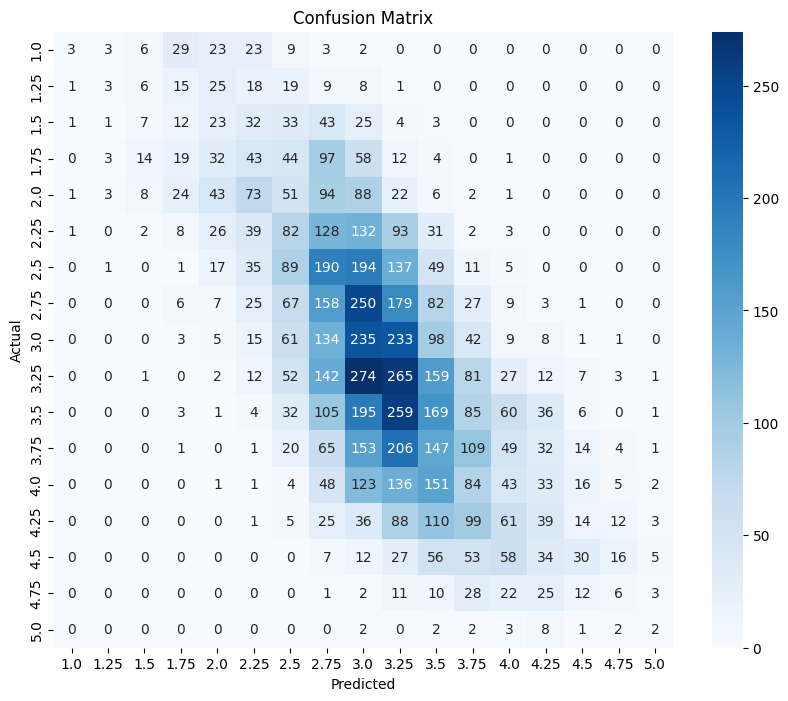

Accuracy: 0.1491
None


In [29]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.Adadelta(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#lr = 0.001
train_model(modelCNN, optimizer, num_epochs=124)

Mean Squared Error: 0.3938 and Mean Absolute Error: 0.5064


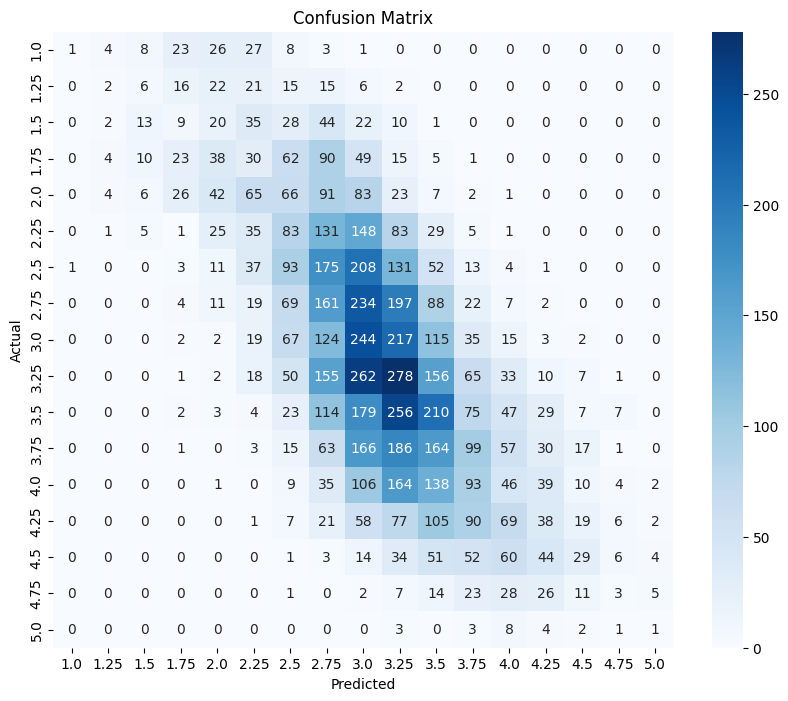

Accuracy: 0.1561


In [30]:
evaluate_model(modelCNN, train_loader,conf=True)

# Official Test Data

In [31]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/test'
test_label = {}
lenghts = []
for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            test_label[filename] = data['audio_data']
            lenghts.append(len(data['audio_data']))
print(max(lenghts))
            

100%|██████████| 1863/1863 [00:03<00:00, 477.23it/s]

133534


In [32]:
for recording_test in test_label:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(test_label[recording_test], (max_length // len(test_label[recording_test]) + 1))[:max_length]
    test_label[recording_test] = repeated_recording
    
for i in test_label:
    print(i, test_label[i].shape)



10011.pkl (174625,)
10025.pkl (174625,)
10033.pkl (174625,)
10036.pkl (174625,)
10043.pkl (174625,)
10067.pkl (174625,)
10074.pkl (174625,)
10079.pkl (174625,)
10083.pkl (174625,)
10090.pkl (174625,)
10092.pkl (174625,)
10097.pkl (174625,)
10099.pkl (174625,)
10110.pkl (174625,)
10116.pkl (174625,)
10120.pkl (174625,)
10149.pkl (174625,)
10179.pkl (174625,)
10184.pkl (174625,)
10189.pkl (174625,)
10191.pkl (174625,)
10192.pkl (174625,)
10194.pkl (174625,)
10200.pkl (174625,)
10202.pkl (174625,)
10204.pkl (174625,)
10206.pkl (174625,)
10207.pkl (174625,)
10216.pkl (174625,)
10222.pkl (174625,)
10224.pkl (174625,)
10235.pkl (174625,)
10236.pkl (174625,)
10240.pkl (174625,)
10242.pkl (174625,)
10251.pkl (174625,)
10253.pkl (174625,)
10259.pkl (174625,)
10267.pkl (174625,)
10271.pkl (174625,)
10277.pkl (174625,)
10279.pkl (174625,)
10286.pkl (174625,)
10287.pkl (174625,)
10288.pkl (174625,)
10290.pkl (174625,)
10291.pkl (174625,)
10293.pkl (174625,)
10306.pkl (174625,)
10315.pkl (174625,)


In [33]:
FinalTestAudio = []
for i in test_label:
    FinalTestAudio.append(test_label[i])

FinalTestDataset = torch.tensor(FinalTestAudio, dtype=torch.float32).unsqueeze(1)

results = predict(modelCNN, FinalTestDataset, device)
print(len(results))


1863


In [34]:
import pandas as pd
labels_final = test_label.keys()
labels_final = list(labels_final)   
df = pd.DataFrame({'ID': labels_final, 'Label': results})
df.to_csv('results3.csv', index=False)

In [35]:
df

,ID,Label
0,10011.pkl,3.208400
1,10025.pkl,1.919598
2,10033.pkl,3.702743
3,10036.pkl,3.106718
4,10043.pkl,4.340781
...,...,...
1858,22393.pkl,3.560573
1859,22394.pkl,3.441071
1860,22400.pkl,4.751411
1861,22401.pkl,2.092293
